In [1]:
# === Data loading (robust for single/multiple tickers) ===
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

tickers = ["AAPL", "MSFT", "GOOG"] # 你要回測的股票清單

# 建議：group_by="column" 讓欄位成為 MultiIndex: (欄位名, Ticker)
df = yf.download(
    tickers,
    start="2020-01-01",
    auto_adjust=True, # 自動做除權息調整；新版其實已 default True
    progress=False,
    group_by="column"
)

# 依據 df.columns 結構，安全取得「價格矩陣」
if isinstance(df.columns, pd.MultiIndex):
    # 第一層會是欄位名（'Close' 或 'Adj Close'等），第二層是 Ticker
    level0 = df.columns.get_level_values(0)
    field = "Adj Close" if "Adj Close" in level0 else "Close"
    prices = df[field].copy() # 取得 (Date x Ticker) 的價錢表
else:
    # 單一股票時，df 是單層欄位 -> 把欄位改名成 ticker 名稱，形成 (Date x 1欄)
    # 優先用 Adj Close，沒有就用 Close
    col = "Adj Close" if "Adj Close" in df.columns else "Close"
    prices = df[[col]].rename(columns={col: tickers[0]}).copy()

# 清掉全空列（例如一開始/假日）
prices = prices.dropna(how="all")

# 便於你確認
print(prices.columns) # 應該是每個 ticker 當欄位
print(prices.head())

Index(['AAPL', 'GOOG', 'MSFT'], dtype='object', name='Ticker')
Ticker           AAPL       GOOG        MSFT
Date                                        
2020-01-02  72.538528  67.964508  153.042328
2020-01-03  71.833298  67.630989  151.136642
2020-01-06  72.405678  69.298576  151.527313
2020-01-07  72.065125  69.255333  150.145721
2020-01-08  73.224426  69.801094  152.537292


In [15]:
import yfinance as yf
import pandas as pd 

tickers = ["AAPL", "MSFT", "GOOG"]
          
# 下載資料 (自動除權息調整)
df = yf.download(tickers, start="2020-01-01", auto_adjust=True)

# 如果是多股票 (MultiIndex) vs 單股票 (單層欄位)
if isinstance(df.columns, pd.MultiIndex):
    prices = pd.concat({t: df[t]["Close"] for t in tickers}, axis=1)
else:
    prices = df[["Close"]].rename(columns={"Close": tickers[0]})

# 移除全為 NaN 的行
prices = prices.dropna(how="all")

# auto_adjust=True → 沒有 "Adj Close"，只用已調整的 "Close"

# MultiIndex（多股票） vs 單一股票 都處理
if isinstance(df.columns, pd.MultiIndex):
    field = "Close" # auto_adjust=True 時固定用 Close
    prices = df[field]
else:
    field = "Close"
    prices = df[[field]].rename(columns={field: tickers[0]})

# 假設 prices 已經是下載好的 DataFrame
prices = prices.asfreq('B') # B = Business day frequency (只留工作日)
prices = prices.ffill() # 缺的日子用前一天補

print(prices.columns) # 應該見到每隻ticker做欄名
print(prices.head())

[*********************100%***********************]  3 of 3 completed


KeyError: 'AAPL'

In [9]:
%run -i import_library_.ipynb


Index(['AAPL', 'MSFT', 'GOOG'], dtype='object', name='Ticker')
Ticker           AAPL        MSFT       GOOG
Date                                        
2020-01-02  72.538513  153.042267  67.964508
2020-01-03  71.833290  151.136673  67.630989
2020-01-06  72.405685  151.527313  69.298576
2020-01-07  72.065147  150.145706  69.255341
2020-01-08  73.224396  152.537323  69.801094


In [10]:
# --- performance stats helper ---
def perf_stats(eq, daily_ret):
    n = len(eq)
    stats = {
        "CumReturn": eq.iloc[-1] / eq.iloc[0] - 1,
        "CAGR": (eq.iloc[-1] / eq.iloc[0]) ** (252.0 / n) - 1 if n > 0 else float("nan"),
        "AnnVol": daily_ret.std() * (252 ** 0.5),
        "Sharpe": daily_ret.mean() / daily_ret.std() * (252 ** 0.5) if daily_ret.std() > 0 else float("nan"),
        "MaxDD": (eq / eq.cummax() - 1).min(),
        "HitRate": (daily_ret > 0).sum() / len(daily_ret) if len(daily_ret) else float("nan"),
    }
    return stats

# --- single-ticker MA backtest helper (若已經在此檔定義就不用再貼) ---
def backtest(close, ma_short=20, ma_long=50):
    daily_ret = close.pct_change().fillna(0.0)
    ma_s = close.rolling(ma_short).mean()
    ma_l = close.rolling(ma_long).mean()
    signal = (ma_s > ma_l).astype(int)
    pos = signal.shift(1).fillna(0)
    strat_ret = pos * daily_ret
    equity = (1 + strat_ret).cumprod()
    return pd.DataFrame({
        "Close": close, "MA_Short": ma_s, "MA_Long": ma_l,
        "Signal": signal, "Position": pos, "DailyRet": strat_ret, "Equity": equity
    })

port_ret head:
 Date
2020-01-02    0.0
2020-01-03    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
dtype: float64
port_eq head:
 Date
2020-01-02    1.0
2020-01-03    1.0
2020-01-06    1.0
2020-01-07    1.0
2020-01-08    1.0
2020-01-09    1.0
2020-01-10    1.0
2020-01-13    1.0
2020-01-14    1.0
2020-01-15    1.0
dtype: float64


,CumReturn,CAGR,AnnVol,Sharpe,MaxDD,HitRate
Portfolio (EW),85.02%,11.56%,16.4%,0.00,-33.88%,42.7%


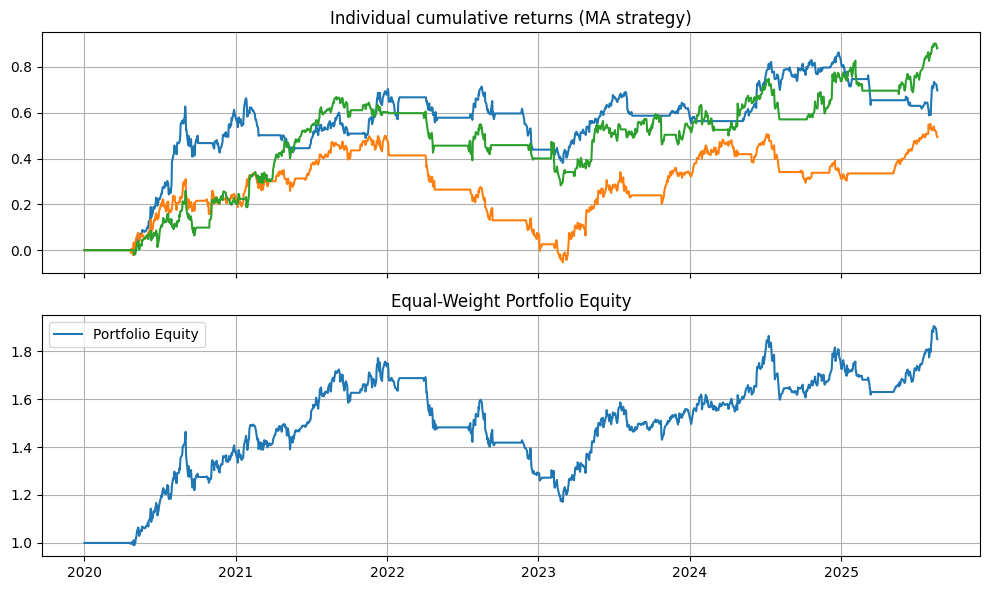

[                       0%                       ]

MultiIndex([('Adj Close', 'AAPL'),
            ('Adj Close', 'GOOG'),
            ('Adj Close', 'MSFT'),
            (    'Close', 'AAPL'),
            (    'Close', 'GOOG'),
            (    'Close', 'MSFT'),
            (     'High', 'AAPL'),
            (     'High', 'GOOG'),
            (     'High', 'MSFT'),
            (      'Low', 'AAPL'),
            (      'Low', 'GOOG'),
            (      'Low', 'MSFT'),
            (     'Open', 'AAPL'),
            (     'Open', 'GOOG'),
            (     'Open', 'MSFT'),
            (   'Volume', 'AAPL'),
            (   'Volume', 'GOOG'),
            (   'Volume', 'MSFT')],
           names=['Price', 'Ticker'])


[*********************100%***********************]  3 of 3 completed


,CumReturn,CAGR,AnnVol,Sharpe,MaxDD,HitRate
Portfolio (EW),2.298427,0.236448,0.282064,0.89373,-0.349825,0.548023


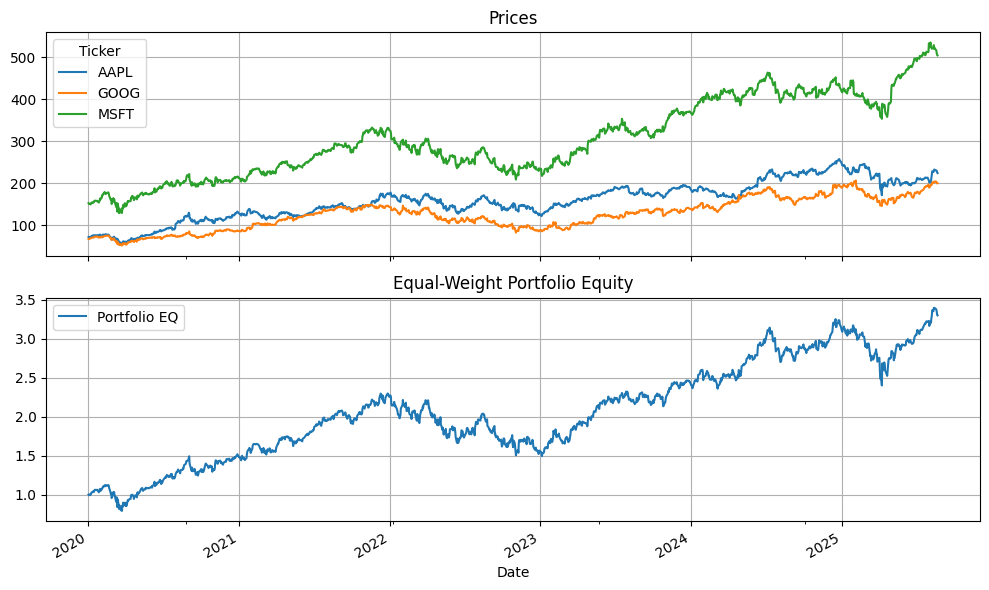

,CumReturn,CAGR,AnnVol,Sharpe,MaxDD,HitRate
Portfolio (EW),2.328473,0.238631,0.282163,0.894046,-0.349825,0.548023


,CumReturn,CAGR,AnnVol,Sharpe,MaxDD,HitRate
Portfolio (EW),232.85%,23.86%,28.22%,0.89,-34.98%,54.8%


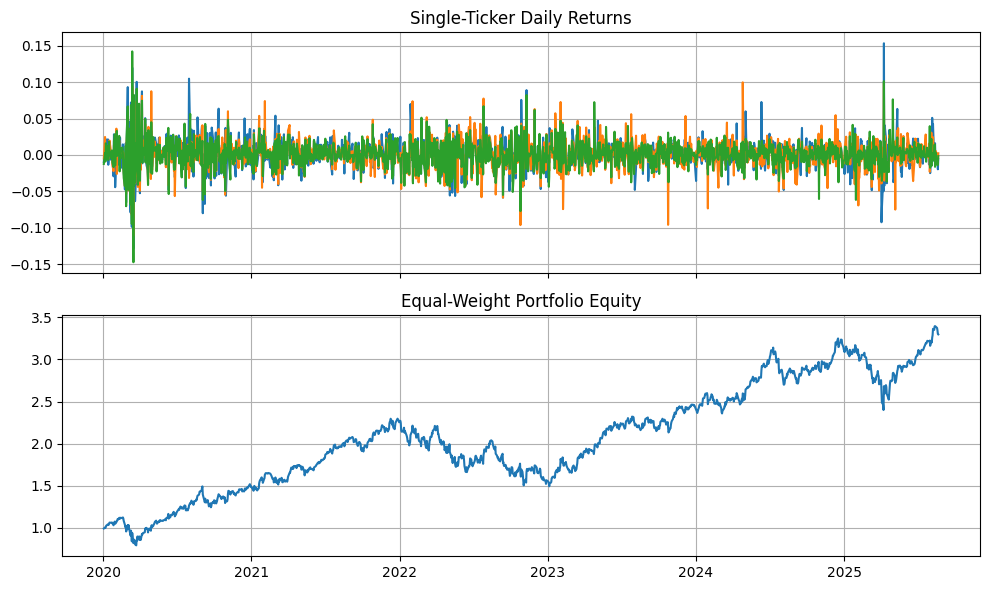

,CumReturn,CAGR,AnnVol,Sharpe,MaxDD,HitRate
Portfolio (EW),85.01%,11.56%,16.37%,0.75,-33.88%,54.5%


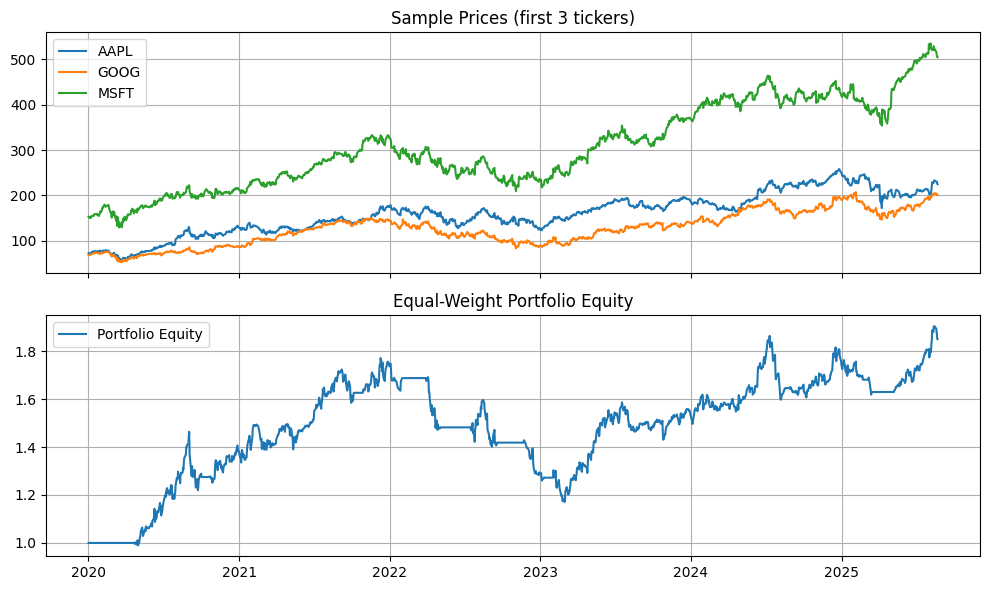

In [11]:
# === Portfolio backtest (equal-weight across all tickers) ===
import yfinance as yf
import pandas as pd

def backtest(series, ma_short=20, ma_long=50):
    """簡單MA交叉回測，回傳日報酬和權益曲線"""
    ma_s = series.rolling(ma_short).mean()
    ma_l = series.rolling(ma_long).mean()

    # 產生交易訊號：短均線上穿長均線 = 做多
    signal = (ma_s > ma_l).astype(int)
    signal = signal.shift(1).fillna(0) # 用前一天的訊號，避免未來函數

    # 計算日報酬
    daily_ret = series.pct_change().fillna(0)
    strat_ret = daily_ret * signal

    # 權益曲線
    equity = (1 + strat_ret).cumprod()

    out = pd.DataFrame({
        "DailyRet": strat_ret,
        "Equity": equity
    })
    return out
# ===== B) 對每個股票跑策略，收集日報酬 =====
rets = {}
eqs = {}
for ticker in prices.columns:
    bt_i = backtest(prices[ticker], ma_short=20, ma_long=50) # 用你上面的函數
    rets[ticker] = bt_i["DailyRet"]
    eqs[ticker] = bt_i["Equity"]

# ===== C) 合成等權投資組合 =====
import pandas as pd
rets_df = pd.DataFrame(rets).dropna(how="all")
eqs_df = pd.DataFrame(eqs).dropna(how="all")

# 每天等權平均（缺值視為0回報）
port_ret = rets_df.mean(axis=1).fillna(0.0)
port_eq = (1.0 + port_ret).cumprod()

# （可選）快速檢查不是全0
print("port_ret head:\n", port_ret.head(10))
print("port_eq head:\n", port_eq.head(10))

# ===== D) 顯示績效與畫圖 =====
def perf_stats(eq, daily_ret):
    n = len(eq)
    stats = {
        "CumReturn": eq.iloc[-1] / eq.iloc[0] - 1,
        "CAGR": (eq.iloc[-1] / eq.iloc[0])**(252.0/n) - 1 if n>0 else float("nan"),
        "AnnVol": daily_ret.std()*(252**0.5),
        "Sharpe": daily_ret.mean()/ (daily_ret.std()*(252**0.5)) if daily_ret.std()>0 else float("nan"),
        "MaxDD": (eq/eq.cummax() - 1).min(),
        "HitRate": (daily_ret>0).sum()/len(daily_ret) if len(daily_ret)>0 else float("nan"),
    }
    return stats

stats = perf_stats(port_eq, port_ret)
display(pd.Series(stats, name="Portfolio (EW)").to_frame().T.style.format({
    "CumReturn":"{:.2%}", "CAGR":"{:.2%}", "AnnVol":"{:.1%}",
    "Sharpe":"{:.2f}", "MaxDD":"{:.2%}", "HitRate":"{:.1%}"
}))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(10,6), sharex=True)
ax[0].plot(rets_df.index, rets_df.cumsum()) # 個股累積報酬（可換成 eqs_df 觀察）
ax[0].set_title("Individual cumulative returns (MA strategy)")
ax[0].grid(True)

ax[1].plot(port_eq.index, port_eq, label="Portfolio Equity")
ax[1].set_title("Equal-Weight Portfolio Equity")
ax[1].grid(True)
ax[1].legend()
plt.tight_layout(); plt.show()    
tickers = ["AAPL", "MSFT", "GOOG"]

df = yf.download(tickers, start="2020-01-01", auto_adjust=True, group_by="column", progress=False)
if isinstance(df.columns, pd.MultiIndex):
    prices = df["Close"] # 如果是多股票
else:
    prices = df[["Close"]].rename(columns={"Adj Close": tickers[0]})
# 如果係 MultiIndex（多隻股票）
# --- 將 yfinance 下載嘅 df 轉成單層 columns 的 prices (處理單股/多股兩種情況) ---
import pandas as pd

# 例：df = yf.download(tickers, start="2020-01-01", auto_adjust=True, group_by="column")

if isinstance(df.columns, pd.MultiIndex):
    # 多股票：df.columns 第一層係欄位名（Close / Adj Close），第二層係 ticker
    lvl0 = df.columns.get_level_values(0)
    field = "Adj Close" if "Adj Close" in lvl0 else "Close"
    prices = df[field]
    # 只保留你要求的 tickers 順序
    prices = prices.reindex(columns=[t for t in tickers if t in prices.columns])
else:
    # 單一股票：df 係單層 columns，需要改名做 ticker 名
    field = "Adj Close" if "Adj Close" in df.columns else "Close"
    prices = df[[field]].rename(columns={field: tickers[0]})

# 清理全 NaN 行
prices = prices.dropna(how="all")
def perf_stats(eq, daily_ret):
    n = len(eq)
    stats = {
        "CumReturn": eq.iloc[-1] / eq.iloc[0] - 1,
        "CAGR": (eq.iloc[-1] / eq.iloc[0]) ** (252.0 / n) - 1,
        "AnnVol": daily_ret.std() * (252 ** 0.5),
        "Sharpe": daily_ret.mean() / daily_ret.std() * (252 ** 0.5),
        "MaxDD": (eq / eq.cummax() - 1).min(),
        "HitRate": (daily_ret > 0).sum() / len(daily_ret),
    }
    return stats

# --- single-ticker MA backtest helper (若已經在此檔定義就不用再貼) ---

tickers = ["AAPL", "MSFT", "GOOG"]

df = yf.download(tickers, start="2020-01-01", auto_adjust=False, progress=False)

# --- 檢查欄位，並安全取得收盤價矩陣為 prices ---
print(df.columns) # 讓你看到實際欄位（是否 MultiIndex & 有沒有 Adj Close）

# 下載並自動用 Adj Close（含分割/股息調整）
df = yf.download(tickers, start="2020-01-01", auto_adjust=True)

# 決定要用的欄位名稱（有 Adj Close 就用，否則退回 Close）
if isinstance(df.columns, pd.MultiIndex):
    field = "Adj Close" if "Adj Close" in df.columns.get_level_values(0) else "Close"
    prices = df[field] # 多股票：直接取出該層
else:
    field = "Adj Close" if "Adj Close" in df.columns else "Close"
    prices = df[[field]].rename(columns={field: tickers[0]}) # 單一股票：改欄名成第一個ticker

prices = prices.dropna(how="all")
import pandas as pd
import yfinance as yf

# === Data loading (safe for newest yfinance) ===
import pandas as pd
import yfinance as yf

tickers = ["AAPL", "MSFT", "GOOG"]

df = yf.download(
    tickers,
    start="2020-01-01",
    auto_adjust=True, # 新版其實已預設 True，但寫清楚更穩陣
    progress=False,
    group_by="column" # 多股票時回傳 MultiIndex: 第一層欄位名, 第二層 Ticker
)

# yfinance 在 auto_adjust=True 下，已將調整後收市價放在 "Close"
field = "Close"

# 多股票 vs. 單股票：統一做成 columns=每隻ticker 的 DataFrame
if isinstance(df.columns, pd.MultiIndex):
    prices = df[field].copy() # 直接拎整個 "Close" 子表
else:
    prices = df[[field]].rename(columns={field: tickers[0]})

# 去除全空行，並前向補值（解決假期/缺失）
prices = prices.dropna(how="all").ffill()


# 3) 個股日報酬
rets_df = prices.pct_change().fillna(0.0)

# 4) 等權投組日報酬 & 權益曲線
port_ret = rets_df.mean(axis=1).fillna(0.0) # ← 你問的這一行，就是取每天的等權平均
port_eq = (1.0 + port_ret).cumprod()

# 5) 簡單績效指標（可選）
def perf_stats(eq: pd.Series, daily_ret: pd.Series):
    n = len(eq)
    if n == 0:
        return {"CumReturn": float("nan"), "CAGR": float("nan"),
                "AnnVol": float("nan"), "Sharpe": float("nan"),
                "MaxDD": float("nan"), "HitRate": float("nan")}
    stats = {
        "CumReturn": eq.iloc[-1]/eq.iloc[0] - 1,
        "CAGR" : (eq.iloc[-1]/eq.iloc[0])**(252.0/n) - 1 if n > 0 else float("nan"),
        "AnnVol" : daily_ret.std() * (252 ** 0.5),
        "Sharpe" : (daily_ret.mean() / daily_ret.std()) * (252 ** 0.5) if daily_ret.std() > 0 else float("nan"),
        "MaxDD" : (eq/eq.cummax() - 1).min(),
        "HitRate" : (daily_ret > 0).sum() / (daily_ret != 0).sum() if (daily_ret != 0).sum() > 0 else float("nan"),
    }
    return stats

stats = perf_stats(port_eq, port_ret)
display(pd.Series(stats, name="Portfolio (EW)").to_frame().T)

# 6) 畫圖（可選）
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
prices.plot(ax=ax[0]); ax[0].set_title("Prices"); ax[0].grid(True)
port_eq.plot(ax=ax[1], label="Portfolio EQ"); ax[1].set_title("Equal-Weight Portfolio Equity"); ax[1].grid(True); ax[1].legend()
plt.tight_layout(); plt.show()
# quick stats using your perf_stats(eq, daily_ret)
# 假設你前面已跑完每檔個股回測，把日報酬存在 rets 這個 dict：
# rets[ticker] = bt_i["DailyRet"]

# 1) 組成 DataFrame（index=日期, columns=ticker）
# 將股價轉換成日報酬
rets_df = prices.pct_change().dropna(how="all")

# 計算等權投資組合的日報酬
port_ret = rets_df.mean(axis=1).fillna(0.0)


# 2) 等權投資組合的日報酬（每一天對所有有資料的股票取平均）
port_ret = rets_df.mean(axis=1).fillna(0.0)

# 3) 權益曲線（從 1 起算）
port_eq = (1.0 + port_ret).cumprod()

# 4) 然後再算績效
stats = perf_stats(port_eq, port_ret)
display(pd.Series(stats, name="Portfolio (EW)").to_frame().T)
stats = perf_stats(port_eq, port_ret)

display(
    pd.Series(stats, name="Portfolio (EW)")
        .to_frame()
        .T
        .style.format({
        "CumReturn": "{:.2%}",
        "CAGR": "{:.2%}",
        "AnnVol": "{:.2%}",
        "Sharpe": "{:.2f}",
        "MaxDD": "{:.2%}",
        "HitRate": "{:.1%}",
    })
)

# plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(rets_df.index, rets_df)
ax[0].set_title("Single-Ticker Daily Returns")
ax[0].grid(True)

ax[1].plot(port_eq.index, port_eq)
ax[1].set_title("Equal-Weight Portfolio Equity")
ax[1].grid(True)

plt.tight_layout()
plt.show()


prices = prices.dropna(how="all")
assert "prices" in globals(), "prices DataFrame not found. Run the data-loading cell first."

# run the existing single-ticker backtest for each column
rets = {}
eqs = {}
for ticker in prices.columns:
    bt_i = backtest(prices[ticker]) # uses your backtest(ma_short=20, ma_long=50) default
    rets[ticker] = bt_i["DailyRet"]
    eqs[ticker] = bt_i["Equity"]

import pandas as pd
rets_df = pd.DataFrame(rets).dropna(how="all")
eqs_df = pd.DataFrame(eqs).dropna(how="all")

# equal-weight portfolio
port_ret = rets_df.mean(axis=1).fillna(0.0)
port_eq = (1.0 + port_ret).cumprod()

# quick stats using your perf_stats(eq, daily_ret)
stats = perf_stats(port_eq, port_ret)
display(pd.Series(stats, name="Portfolio (EW)").to_frame().T.style.format({
    "CumReturn": "{:.2%}", "CAGR": "{:.2%}", "AnnVol": "{:.2%}",
    "Sharpe": "{:.2f}", "MaxDD": "{:.2%}", "HitRate": "{:.1%}"
}))

# plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(10,6), sharex=True)

# (top) show a couple of closes for context (limit to first 3 to avoid clutter)
for c in prices.columns[:3]:
    ax[0].plot(prices.index, prices[c], label=c)
ax[0].set_title("Sample Prices (first 3 tickers)")
ax[0].legend()
ax[0].grid(True)

# (bottom) portfolio equity curve
ax[1].plot(port_eq.index, port_eq, label="Portfolio Equity")
ax[1].set_title("Equal-Weight Portfolio Equity")
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()

In [12]:
df = yf.download(tickers, start="2020-01-01", auto_adjust=True)


[*********************100%***********************]  3 of 3 completed


In [13]:
tickers = ["AAPL", "MSFT", "GOOG"]
df = yf.download(tickers, start="2020-01-01")
if isinstance(df.columns, pd.MultiIndex):
    # 如果是多股票（欄位有兩層）
    prices = df["Adj Close"]
else:
    # 如果只有一隻股票（單層欄位）
    prices = df[["Adj Close"]]

prices = prices.dropna(how="all")

C:\Users\rhcy9\AppData\Local\Temp\ipykernel_31824\4232336981.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start="2020-01-01")
[*********************100%***********************]  3 of 3 completed


KeyError: 'Adj Close'

In [14]:
print(df.head())
print(df.columns)

Price           Close                              High             \
Ticker           AAPL       GOOG        MSFT       AAPL       GOOG   
Date                                                                 
2020-01-02  72.538506  67.964508  153.042328  72.598884  68.002778   
2020-01-03  71.833282  67.630989  151.136658  72.594048  68.219494   
2020-01-06  72.405640  69.298576  151.527298  72.444283  69.412394   
2020-01-07  72.065147  69.255341  150.145706  72.671341  69.734988   
2020-01-08  73.224411  69.801094  152.537323  73.526303  70.161948   

Price                         Low                              Open  \
Ticker            MSFT       AAPL       GOOG        MSFT       AAPL   
Date                                                                  
2020-01-02  153.147139  71.292296  66.681136  150.860371  71.545882   
2020-01-03  152.403913  71.608677  66.879657  150.603080  71.765659   
2020-01-06  151.594002  70.702975  67.101136  149.126182  70.954151   
2020-01-07  1

In [ ]:
# ==== 1) Single-ticker helper: use your signal logic ====
def signals_ma_rsi_for_series(s):
    """Return a -1/0/1 signal Series for one ticker (same rules you used)."""
    ma20 = s.rolling(20).mean()
    ma50 = s.rolling(50).mean()

    # RSI(14) in pure pandas
    d = s.diff()
    gain = d.clip(lower=0).rolling(14).mean()
    loss = (-d.clip(upper=0)).rolling(14).mean()
    rs = gain / loss
    rsi14 = 100 - (100 / (1 + rs))

    sig = pd.Series(0, index=s.index, dtype=int)
    sig[(ma20 > ma50)] = 1
    sig[(ma20 < ma50)] = -1
    # optional RSI filter example (uncomment if you want):
    # sig[rsi14 > 70] = -1
    # sig[rsi14 < 30] = 1
    return sig

def backtest_single_ticker(close, ma_short=20, ma_long=50):
    """Your simple MA cross backtest for one ticker, returns DailyRet and other columns."""
    daily_ret = close.pct_change().fillna(0.0)
    ma_s = close.rolling(ma_short).mean()
    ma_l = close.rolling(ma_long).mean()
    signal = (ma_s > ma_l).astype(int) # 1 long, 0 cash (no short)
    pos = signal.shift(1).fillna(0)
    strat_ret = pos * daily_ret
    equity = (1 + strat_ret).cumprod()
    return pd.DataFrame({"DailyRet": strat_ret, "Equity": equity})

# ==== 2) Portfolio backtest across all tickers in `prices` ====
def backtest_portfolio(
    prices,
    rebalance="W-FRI", # rebal freq: W-FRI, M, etc.
    tx_cost_bps=10, # round-trip cost in basis points (10 = 0.10%)
    allow_short=False, # if True, allow -1 weights; else long-only
    weight_scheme="equal" # "equal" or "signal_strength" (both long-only here)
):
    """
    Run per-ticker backtests + combine into a portfolio with scheduled rebalancing and costs.
    Returns: (portfolio_df, per_ticker_bts)
    """
    tickers = list(prices.columns)
    # 2a) Build per-ticker daily returns (strategy) and signals
    per_bt = {}
    per_sig = {}
    for t in tickers:
        s = prices[t].dropna()
        if s.empty:
            continue
        per_sig[t] = signals_ma_rsi_for_series(s)
        bt = backtest_single_ticker(s) # uses MA cross rules
        per_bt[t] = bt.reindex(prices.index).fillna(0.0)

    if not per_bt:
        raise ValueError("No valid tickers to backtest.")

    # Align all returns into one DataFrame
    ret_mat = pd.DataFrame({t: per_bt[t]["DailyRet"] for t in per_bt}).fillna(0.0)

    # 2b) Rebalance schedule
    # Rebalance dates are the period-ends per `rebalance`
    rebal_dates = ret_mat.resample(rebalance).last().index
    rebal_mask = ret_mat.index.isin(rebal_dates)

    # 2c) Compute target weights at each rebalance
    W = pd.DataFrame(0.0, index=ret_mat.index, columns=ret_mat.columns)

    for idx in rebal_dates:
        # Only use tickers we actually have on this date
        available = ret_mat.columns[~ret_mat.loc[idx].isna()]

        if weight_scheme == "equal":
            # Long only on positive signals at the **rebalance** date
            longs = []
            for t in available:
                sig = per_sig[t].reindex(ret_mat.index).ffill().fillna(0)
                if sig.loc[idx] > 0:
                    longs.append(t)
            if len(longs) == 0:
                # stay in cash
                pass
            else:
                W.loc[idx, longs] = 1.0 / len(longs)

        else: # "signal_strength" placeholder (same as equal for now)
            longs = []
            for t in available:
                sig = per_sig[t].reindex(ret_mat.index).ffill().fillna(0)
                if sig.loc[idx] > 0:
                    longs.append(t)
            if len(longs) > 0:
                W.loc[idx, longs] = 1.0 / len(longs)

        if allow_short:
            # Example: market-neutral by spreading weights across pos/neg signals
            # (implement when needed)
            pass

    # Carry weights forward until next rebalance
    W = W.replace([np.inf, -np.inf], 0.0).fillna(0.0)
    W = W.where(~rebal_mask[:, None]).replace(np.nan, 0.0) # keep only on rebal days
    W = W.replace(0.0, np.nan).ffill().fillna(0.0)

    # 2d) Portfolio daily returns with transaction costs
    # Turnover = 0.5 * sum(|w_t - w_{t-1}|) across names (per day)
    W_prev = W.shift(1).fillna(0.0)
    turnover = (W.sub(W_prev).abs().sum(axis=1) * 0.5)
    cost = turnover * (tx_cost_bps / 10000.0)

# === Monthly rebalance to equal-weight ===
rebal_dates = prices.resample("M").last().index

# 建立權重表，每個調倉日設為等權重，其餘沿用前值
W = pd.DataFrame(index=prices.index, columns=prices.columns, dtype=float)
W.loc[rebal_dates, :] = 1.0 / len(prices.columns)
W = W.ffill() # 將上一次權重沿用至下一次調倉

# Portfolio daily returns with transaction costs
w_prev = W.shift(1).fillna(0.0)
turnover = (W.sub(w_prev).abs().sum(axis=1) * 0.5)
cost = turnover * (tx_cost_bps / 10000.0)

port_ret_gross = (w_prev * ret_mat).sum(axis=1)
port_ret_net = port_ret_gross - cost
port_eq = (1 + port_ret_net).cumprod()

port = pd.DataFrame({
    "DailyRet": port_ret_net,
    "Equity": port_eq,
    "Turnover": turnover
})

port = pd.DataFrame({
        "DailyRet": port_ret_net,
        "Equity": port_eq,
        "Turnover": turnover
    })

return port, per_bt, W

# ==== 3) Run it ====
# Assumes you already have `prices` (Date index, columns = tickers)
portfolio, per_ticker, W = backtest_portfolio(
    prices,
    rebalance="W-FRI",
    tx_cost_bps=10,
    allow_short=False,
    weight_scheme="equal"
)

# Quick stats
stats = {
    "CumReturn": portfolio["Equity"].iloc[-1] - 1.0,
    "CAGR": (portfolio["Equity"].iloc[-1] ** (252.0 / len(portfolio)) - 1.0) if len(portfolio) > 0 else np.nan,
    "AnnVol": portfolio["DailyRet"].std() * np.sqrt(252),
    "Sharpe": (portfolio["DailyRet"].mean() / portfolio["DailyRet"].std() * np.sqrt(252)) if portfolio["DailyRet"].std() > 0 else np.nan,
    "MaxDD": (portfolio["Equity"] / portfolio["Equity"].cummax() - 1.0).min(),
    "HitRate": (portfolio["DailyRet"] > 0).mean()
}
display(pd.Series(stats, name="Portfolio").to_frame().T)

# Plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
ax[0].plot(portfolio.index, portfolio["Equity"]); ax[0].set_title("Portfolio Equity")
ax[1].plot(portfolio.index, portfolio["DailyRet"].rolling(21).sum()); ax[1].set_title("21D Rolling Sum of Returns")
plt.tight_layout(); plt.show()

In [ ]:
# 1) Inspect the per-ticker daily returns table
print("rets_df columns:", list(rets_df.columns))
display(rets_df.head(10))

# 2) Inspect the equal-weight portfolio daily return
print("port_ret shape:", port_ret.shape)
display(port_ret.head(10))

# 3) (optional) Inspect the portfolio equity curve
print("port_eq shape:", port_eq.shape)
display(port_eq.head(10))